# FVCOM vertical slice along transect

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import iris
import warnings
import pyugrid
import seawater as sw

In [2]:
#url = 'http://crow.marine.usf.edu:8080/thredds/dodsC/FVCOM-Nowcast-Agg.nc'
#url ='http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/hindcasts/30yr_gom3/mean'
#url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/fvcom/hindcasts/30yr_gom3'
url = 'http://www.smast.umassd.edu:8080/thredds/dodsC/FVCOM/NECOFS/Forecasts/NECOFS_GOM3_FORECAST.nc'
ugrid = pyugrid.UGrid.from_ncfile(url)

In [3]:
# [lon,lat] of start point [A] and endpoint [B] for transect

A = [-84, 27]
B = [-82.5, 25.5]

In [4]:
A = [-70, 41]
B = [-69, 42]

In [5]:
A = [-70.11129, 43.479881]   # portland
B = [-66.240095, 40.834688]   # offshore Georges Bank

In [6]:
A = [-70.6, 42.2]    # mass bay
B = [-69.3, 42.5]

In [7]:
lon = ugrid.nodes[:, 0]
lat = ugrid.nodes[:, 1]
triangles = ugrid.faces[:]

triang = mtri.Triangulation(lon, lat, triangles=triangles)

In [8]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='10m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [9]:
def plt_triangle(triang, face, ax=None, **kw):
    if not ax:
        fig, ax = plt.subplots()
    ax.triplot(triang.x[triang.triangles[face]],
               triang.y[triang.triangles[face]],
               triangles=triang.triangles[face], **kw)

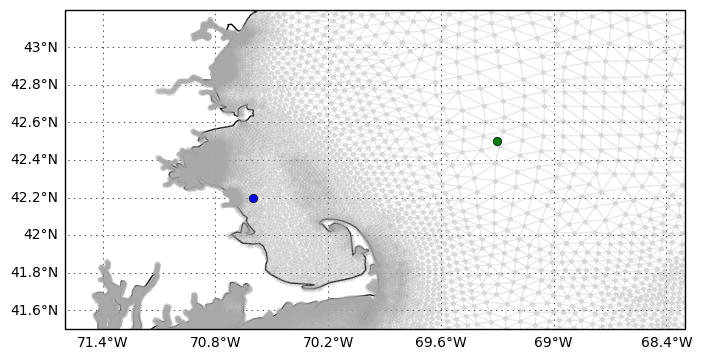

In [10]:
fig, ax = make_map()

kw = dict(marker='.', linestyle='-', alpha=0.25, color='darkgray')
ax.triplot(triang, **kw)  # or lon, lat, triangules
buf=1.0
extent = [lon.min(), lon.max(),
          lat.min(), lat.max()]
extent = [A[0]-buf, B[0]+buf, B[1]-buf, A[1]+buf]
ax.set_extent(extent)
ax.plot(A[0], A[1], 'o')
ax.plot(B[0], B[1], 'o')

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    cubes = iris.load_raw(url)

In [12]:
print(cubes)

0: Times / (1)                         (time: 145; -- : 64)
1: Icing Hazard@10knots / (m C s^-1)   (time: 145; -- : 53087)
2: eastward_sea_water_velocity / (meters s-1) (time: 145; -- : 40; -- : 99137)
3: nodal y-coordinate / (meters)       (-- : 53087)
4: zonal x-coordinate / (meters)       (-- : 99137)
5: upward_sea_water_velocity / (meters s-1) (time: 145; -- : 40; -- : 99137)
6: awy / (1)                           (-- : 3; -- : 99137)
7: zonal y-coordinate / (meters)       (-- : 99137)
8: nodes surrounding element / (1)     (-- : 3; -- : 99137)
9: sea_water_salinity / (0.001)        (time: 145; -- : 40; -- : 53087)
10: barotropic_eastward_sea_water_velocity / (meters s-1) (time: 145; -- : 99137)
11: sea_water_potential_temperature / (degrees_C) (time: 145; -- : 40; -- : 53087)
12: aw0 / (1)                           (-- : 3; -- : 99137)
13: awx / (1)                           (-- : 3; -- : 99137)
14: Icing Hazard@0knots / (m C s^-1)    (time: 145; -- : 53087)
15: barotropic_northwa

In [13]:
cube = cubes.extract_strict('sea_water_potential_temperature')
print(cube)

sea_water_potential_temperature             (time: 145; -- : 40; -- : 53087)
     Dimension coordinates:
          time                                             x         -        -
     Auxiliary coordinates:
          sea_surface_height_above_geoid                   x         -        x
          ocean_sigma_coordinate                           -         x        x
          latitude                                         -         -        x
          longitude                                        -         -        x
          sea_floor_depth_below_geoid                      -         -        x
     Derived coordinates:
          sea_surface_height_above_reference_ellipsoid     x         x        x
     Attributes:
          Conventions: CF-1.0, UGRID-1.0
          CoordinateProjection: init=nad83:1802
          CoordinateSystem: Cartesian
          DODS.dimName: DateStrLen
          DODS.strlen: 26
          DODS_EXTRA.Unlimited_Dimension: time
          GroundWater_Forcing

In [14]:
# Finding the right `num` is tricky.
num = 60

xi = np.linspace(A[0], B[0], num=num, endpoint=True)
yi = np.linspace(A[1], B[1], num=num, endpoint=True)

dist = sw.dist(xi, yi, 'km')[0].cumsum()
dist = np.insert(dist, 0, 0)

In [15]:
# grab a 3D chunk of data at a specific time step
t3d = cube[-1, ...].data

In [16]:
# this uses the CF formula terms to compute the z positions in the vertical
z3d = cube[-1, ...].coord('sea_surface_height_above_reference_ellipsoid').points

In [17]:
# this uses the CF formula terms to compute the z positions in the vertical
#z3d = [z for z in cube[-1,...].coords(axis='z') if z.units.is_convertible(cf_units.Unit('m'))][0].points

In [18]:
def interpolate(triang, xi, yi, data, trifinder=None):
    import matplotlib.tri as mtri
    # We still need to iterate in the vertical :-(
    i, j = data.shape
    slices = []
    for k in range(i):
        interp_lin = mtri.LinearTriInterpolator(triang, data[k, :], trifinder=trifinder)
        slices.append(interp_lin(xi, yi))
    return np.array(slices)

trifinder = triang.get_trifinder()
zi = interpolate(triang, xi, yi, t3d, trifinder=trifinder)
di = interpolate(triang, xi, yi, z3d, trifinder=trifinder)

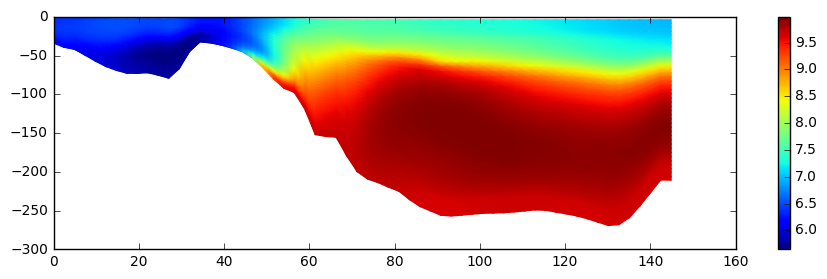

In [19]:
fig, ax = plt.subplots(figsize=(11, 3))
im = ax.pcolormesh(dist, di, zi, shading='gouraud', cmap='jet')
fig.colorbar(im, orientation='vertical');